In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from scipy.integrate import cumulative_trapezoid
from universality import eos as universality_eos
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    dyn_per_square_cm_to_GeV_per_cubic_femtometer,
    nsat
    )

Modify the default crust model

In [2]:
crust = pd.read_csv('../data/eos-draws-default/make-agnostic-processes/ingo-bps-with-cs2c2.csv')

In [3]:
crust

,baryon_density,pressurec2,energy_densityc2,cs2c2
0,6.690488e+00,1.123602e-13,7.757621e+00,1.694600e-11
1,7.911502e+00,1.123602e-12,7.817296e+00,1.355688e-10
2,7.961680e+00,1.123602e-11,7.857078e+00,3.304493e-10
3,8.212574e+00,1.123602e-10,8.105720e+00,3.831341e-10
4,1.169163e+01,1.346106e-09,1.153698e+01,1.670024e-09
...,...,...,...,...
73,1.070478e+14,4.951233e+11,1.079919e+14,7.578690e-03
74,1.137383e+14,5.478749e+11,1.147740e+14,7.983989e-03
75,1.204288e+14,6.034447e+11,1.215592e+14,8.402345e-03
76,1.271193e+14,6.619255e+11,1.283475e+14,8.781323e-03


In [4]:
pressurec2 = crust['pressurec2'].values
energy_densityc2 = crust['energy_densityc2'].values
baryon_density = crust['baryon_density'].values

default_pressure = to_GeV_per_cubic_femtometre(pressurec2)
default_energy_density = to_GeV_per_cubic_femtometre(energy_densityc2)
default_number_density = to_nucleons_per_cubic_femtometre(baryon_density)

default_chemical_potential = (
    default_energy_density+default_pressure
)/default_number_density

In [5]:
uni_crust_pressure = to_GeV_per_cubic_femtometre(
    universality_eos.CRUST_PRESSUREC2
    )
uni_crust_energy_density = to_GeV_per_cubic_femtometre(
    universality_eos.CRUST_ENERGY_DENSITYC2
    )
uni_crust_number_density = to_nucleons_per_cubic_femtometre(
    universality_eos.CRUST_BARYON_DENSITY
    )

uni_crust_chemical_potential = (
    uni_crust_energy_density+uni_crust_pressure
    )/uni_crust_number_density

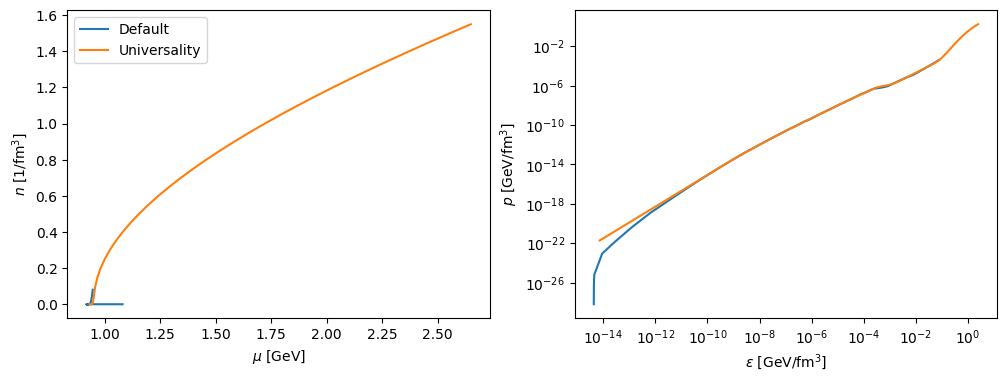

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].plot(
    default_chemical_potential, 
    default_number_density, 
    c='C0',
    label='Default'
    )
axs[0].plot(
    uni_crust_chemical_potential, 
    uni_crust_number_density, 
    c='C1',
    label='Universality'
    )

axs[1].plot(
    default_energy_density,
    default_pressure
)
axs[1].plot(
    uni_crust_energy_density,
    uni_crust_pressure
)

axs[0].set_xlabel(r'$\mu$ [GeV]')
axs[0].set_ylabel(r'$n$ [1/fm$^3$]')

axs[1].set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
axs[1].set_ylabel(r'$p$ [GeV/fm$^3$]')

axs[0].legend();

When we compute the chemical potential from the above it does not behave correctly (namely, it is not a monotonic function). We can take two of the provided arrays and re-compute the third to correct it. We choose to recompute the number density via

$$ n = \epsilon\, \exp\left( -\int \frac{p}{\epsilon + p}\, d\ln \epsilon \right) $$

To see where this expression comes from, we start from the expression

$$ \mathrm{d}\epsilon = \mu ~ \mathrm{d}n, $$

which is a simplified form of the fundamental thermodynamic relation

$$ \mathrm{d}U = T ~ \mathrm{d}S - p ~ \mathrm{d}V + \mu ~ \mathrm{d}N. $$

In the zero-temperature limit express energy, entropy, and particle number as densities $\epsilon$, $s$, and $n$, respectively ($\epsilon = U/V$, etc.). Then replace $\mathrm{d}U$, $\mathrm{d}S$, $\mathrm{d}N$ with $\mathrm{d}U = V ~ \mathrm{d}\epsilon + \epsilon ~ \mathrm{d}V$, etc. Grouping the $\mathrm{d}V$ terms, we can use the Euler relation 

$$ \epsilon + p = \mu n $$

to see the $\mathrm{d}V$ term vanishes, leaving us with $\mathrm{d}\epsilon = \mu ~ \mathrm{d}n$.

Substituting for $\mu$:

$$ \mathrm{d}\epsilon = \frac{\epsilon + p}{n} ~ \mathrm{d}n $$

\begin{align*} 
\implies \int \frac{\mathrm{d}n}{n} &= \int \frac{\mathrm{d}\epsilon}{\epsilon + p} \\[8pt]
\int \mathrm{d}\ln{n} &= \int \frac{\epsilon}{\epsilon + p} ~ \mathrm{d}\ln{\epsilon} \\[8pt]
\ln{n} &= \int \left( 1 - \frac{p}{\epsilon + p} \right) ~ \mathrm{d}\ln{\epsilon} \\[8pt]
\ln{n} &= \ln{\epsilon} - \int \frac{p}{\epsilon + p} ~ \mathrm{d}\ln{\epsilon}
\end{align*}

so finally

$$ n = \epsilon\, \exp\left( -\int \frac{p}{\epsilon + p}\, d\ln \epsilon \right). $$

In [7]:
I = cumulative_trapezoid(
    pressurec2/(energy_densityc2 + pressurec2), 
    x=np.log(energy_densityc2), 
    initial=0
    )

In [8]:
baryon_density_modified = energy_densityc2*np.exp(-I)

In [9]:
cs2c2_modified = np.gradient(pressurec2, energy_densityc2)

In [10]:
crust_modified = pd.DataFrame({
    'baryon_density': baryon_density_modified,
    'pressurec2': pressurec2,
    'energy_densityc2': energy_densityc2,
    'cs2c2': cs2c2_modified
    })

In [11]:
crust_modified

,baryon_density,pressurec2,energy_densityc2,cs2c2
0,7.757621e+00,1.123602e-13,7.757621e+00,1.694600e-11
1,7.817296e+00,1.123602e-12,7.817296e+00,1.592937e-10
2,7.857078e+00,1.123602e-11,7.857078e+00,2.752282e-10
3,8.105720e+00,1.123602e-10,8.105720e+00,4.035215e-10
4,1.153698e+01,1.346106e-09,1.153698e+01,1.455585e-09
...,...,...,...,...
73,1.060385e+14,4.951233e+11,1.079919e+14,7.578643e-03
74,1.126659e+14,5.478749e+11,1.147740e+14,7.983941e-03
75,1.192933e+14,6.034447e+11,1.215592e+14,8.402295e-03
76,1.259207e+14,6.619255e+11,1.283475e+14,8.781285e-03


In [12]:
crust_modified.to_csv(
    '../data/eos-draws-default/make-agnostic-processes/ingo-bps-with-cs2c2-modified.csv', 
    index=False, 
    float_format='%.18e'
    )

Inspect the modified crust model

In [13]:
crust = pd.read_csv('../data/eos-draws-default/make-agnostic-processes/ingo-bps-with-cs2c2-modified.csv')

In [14]:
crust_pressure = to_GeV_per_cubic_femtometre(crust.pressurec2)
crust_energy_density = to_GeV_per_cubic_femtometre(crust.energy_densityc2)
crust_number_density = to_nucleons_per_cubic_femtometre(crust.baryon_density)

crust_chemical_potential = (crust_energy_density+crust_pressure)/crust_number_density

In [15]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

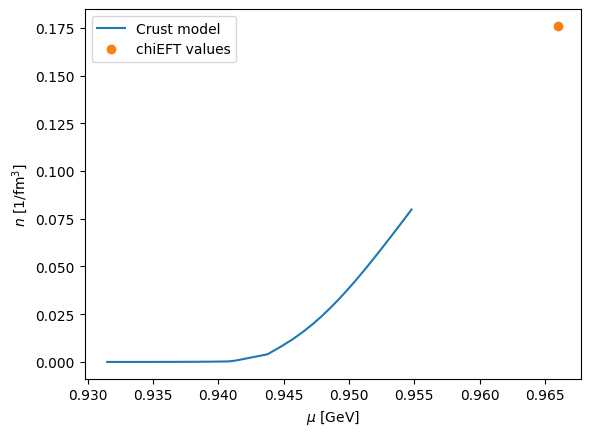

In [16]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density, label='Crust model')
ax.plot(muL, nL, 'o', label='chiEFT values')

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend();

In [17]:
# in http://arxiv.org/abs/1910.09740 its stated that p_ref = 5.4e31 dyn/cm^2,
# which is the pressure they force the GP to approach phi = 6 (i.e., they're
# trying to roughly match some known low-pressure physics)

# I think this is the crust model they used?
from universality import eos

default_crust_pressure = to_GeV_per_cubic_femtometre(eos.CRUST_PRESSUREC2)
default_crust_energy_density = to_GeV_per_cubic_femtometre(eos.CRUST_ENERGY_DENSITYC2)
default_crust_number_density = to_nucleons_per_cubic_femtometre(eos.CRUST_BARYON_DENSITY)

default_crust_chemical_potential = (
    default_crust_energy_density+default_crust_pressure
    )/default_crust_number_density

p_ref = dyn_per_square_cm_to_GeV_per_cubic_femtometer(5.4e31)
p_ref

3.37068e-05

In [18]:
# The index where this reference pressure is in the crust array
p_ref_index = np.argmin(abs(default_crust_pressure-p_ref))
p_ref_index

62

In [19]:
# We modified this to be a higher value in the new GP
p_ref_new = to_GeV_per_cubic_femtometre(3e11)
p_ref_new

0.0001682876581141336

In [20]:
# The index where this reference pressure is in the crust array
p_ref_new_index = np.argmin(abs(crust_pressure-p_ref_new))
p_ref_new_index

69

In [21]:
len(crust_pressure)

78

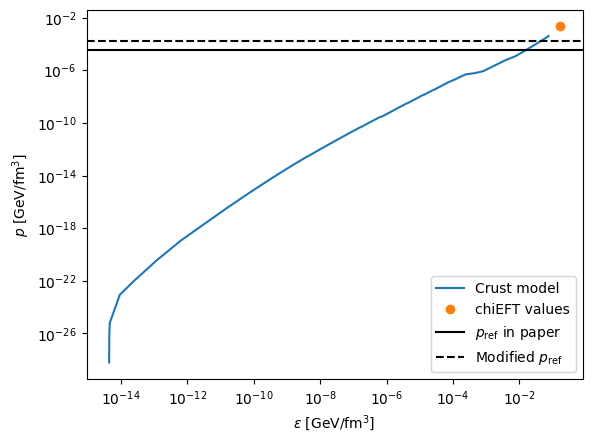

In [22]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(crust_energy_density, crust_pressure, label='Crust model')
ax.plot(epsilonL, pL, 'o', label='chiEFT values')
ax.axhline(p_ref, c='k', label='$p_\mathrm{ref}$ in paper')
ax.axhline(p_ref_new, c='k', linestyle='--', label='Modified $p_\mathrm{ref}$')

ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

ax.legend();

Take an example gp1 draw which was stitched to this crust:

In [23]:
file_path = (
    '../data/eos-draws-modified/gp1/margagn/DRAWmod1000-000000/eos-draw-000005.csv'
)

eos = pd.read_csv(file_path)

eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

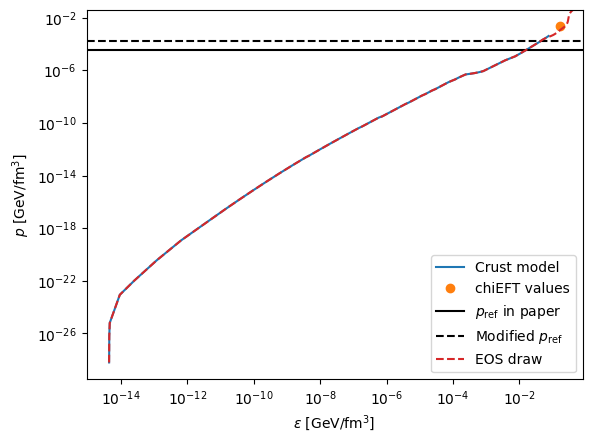

In [24]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(crust_energy_density, crust_pressure, label='Crust model')
ax.plot(epsilonL, pL, 'o', label='chiEFT values')
ax.axhline(p_ref, c='k', label='$p_\mathrm{ref}$ in paper')
ax.axhline(p_ref_new, c='k', linestyle='--', label='Modified $p_\mathrm{ref}$')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(
    eos_energy_density, 
    eos_pressure, 
    linestyle='--', 
    label='EOS draw',
    c='C3'
)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

ax.legend();

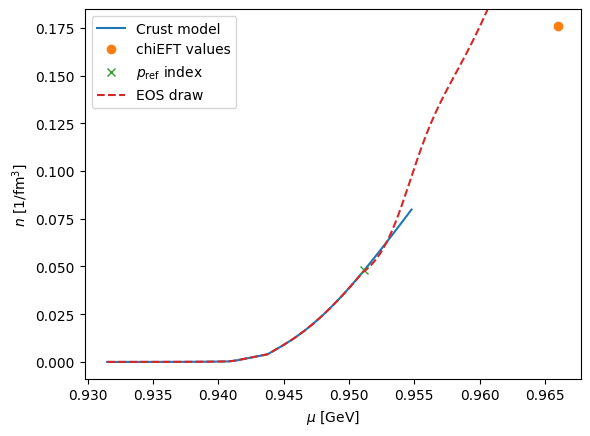

In [25]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density, label='Crust model')
ax.plot(muL, nL, 'o', label='chiEFT values')
ax.plot(
    crust_chemical_potential[p_ref_new_index], 
    crust_number_density[p_ref_new_index], 
    'x', 
    label='$p_\mathrm{ref}$ index'
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(eos_chemical_potential, eos_number_density, linestyle='--', label='EOS draw')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend();

Plot multiple EOS draws

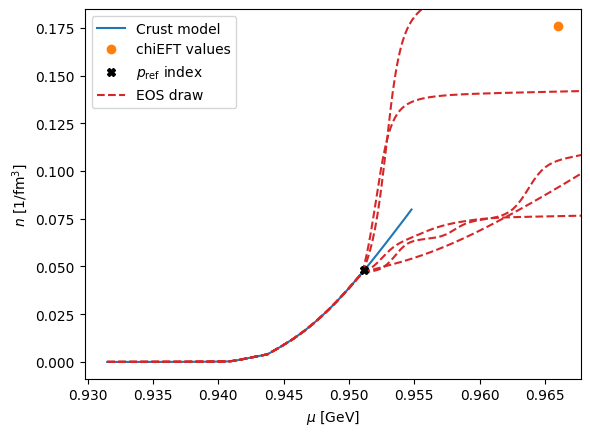

In [26]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density, label='Crust model')
ax.plot(muL, nL, 'o', label='chiEFT values')
ax.plot(
    crust_chemical_potential[p_ref_new_index], 
    crust_number_density[p_ref_new_index], 
    'X', 
    label='$p_\mathrm{ref}$ index',
    c='k',
    zorder=5
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

n_draws = 5
for n in range(n_draws):

    file_path = (
        f'../data/eos-draws-modified/gp1/margagn/DRAWmod1000-000000/eos-draw-00000{n}.csv'
    )

    eos = pd.read_csv(file_path)

    eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

    ax.plot(
        eos_chemical_potential, 
        eos_number_density, 
        linestyle='--', 
        label='EOS draw' if n == 0 else None,
        c='C3'
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend();

The old (unmodified) EOS draws have strange behaviour in the $\mu \text{--} n$ plane. Is this because of the crust?

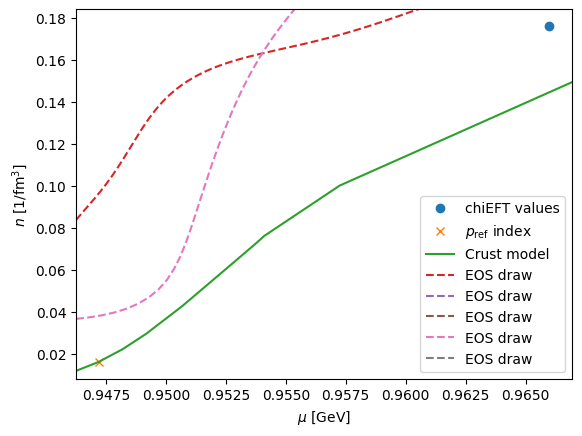

In [27]:
collated_eos_path = '../data/eos-draws-default/collated_np_all_post.csv'
target_dir = '../data/eos-draws-default/mrgagn'

collated_eos = pd.read_csv(collated_eos_path)

fig, ax = plt.subplots()

ax.plot(muL, nL, 'o', label='chiEFT values')
ax.plot(
    default_crust_chemical_potential[p_ref_index], 
    default_crust_number_density[p_ref_index], 
    'x', 
    label='$p_\mathrm{ref}$ index'
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(default_crust_chemical_potential, default_crust_number_density, label='Crust model')

n_draws = 5
for eos in collated_eos.eos[:n_draws]:

    eos = int(eos)
    eos = pd.read_csv(f'{target_dir}/DRAWmod1000-{eos//1000:06}/eos-draw-{eos:06}.csv')

    eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

    ax.plot(eos_chemical_potential, eos_number_density, linestyle='--', label='EOS draw')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend();

In energy density vs pressure things look better behaved. We can see the low-pressure stitch makes things smoother when we join to the crust.

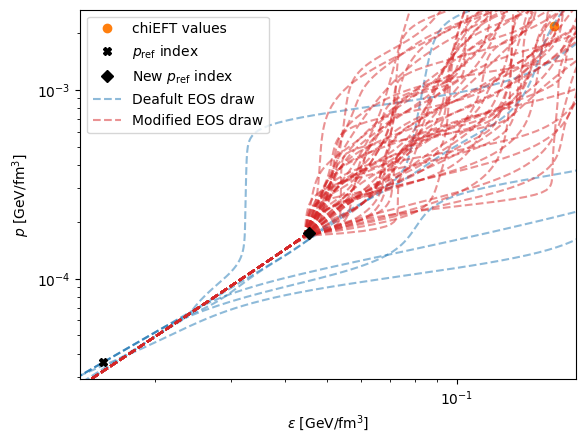

In [28]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(epsilonL, pL, 'o', c='C1', label='chiEFT values')
ax.plot(
    default_crust_energy_density[p_ref_index], 
    default_crust_pressure[p_ref_index], 
    'X', 
    label='$p_\mathrm{ref}$ index',
    zorder=10,
    c='k',
    )
ax.plot(
    crust_energy_density[p_ref_new_index], 
    crust_pressure[p_ref_new_index], 
    'D', 
    label='New $p_\mathrm{ref}$ index',
    zorder=10,
    c='k'
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# ax.plot(crust_energy_density, crust_pressure, label='Crust model', c='C2')

n_eos = 50
for i, eos in enumerate(collated_eos.eos[:6]):

    eos = int(eos)

    eos = pd.read_csv(f'{target_dir}/DRAWmod1000-{eos//1000:06}/eos-draw-{eos:06}.csv')

    eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

    ax.plot(
        eos_energy_density, 
        eos_pressure, 
        linestyle='--', 
        label='Deafult EOS draw' if i == 0 else None, 
        c='C0',
        alpha=0.5)

for n in range(n_eos):

    file_path = (
        f'../data/eos-draws-modified/gp1/margagn/DRAWmod1000-000000/eos-draw-{n:06}.csv'
    )

    eos = pd.read_csv(file_path)

    eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

    ax.plot(
        eos_energy_density, 
        eos_pressure, 
        linestyle='--', 
        label='Modified EOS draw' if n == 0 else None, 
        c='C3',
        alpha=0.5
        )

# ax.set_xlim(1e-3, 0.2)
# ax.set_ylim(1e-6, 0.025)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel('$p$ [GeV/fm$^3$]')

ax.legend();